In [1]:
import os 
os.chdir('E:\Ecole\Year 3\Projet 3A\Code')

In [2]:
%run all_data.py

In [3]:
PDZ_Data = Data()
PDZ_Data.load_data()
PDZ_Data.y_manip_nbind

0.9664341761115954

In [20]:
## Convenience functions to convert between letter sequences and indexed sequences. 
## The index for each amino acid is computed using the enumeration presented in the file "MDSM_01_stiffler_bis.xls" 
def convert2seq(seq_int):
    return [PDZ_Data.aminoacids[i] for i in seq_int]
def convert2int(seq_pep):
    return [PDZ_Data.aminoacids.index(pep) for pep in seq_pep]

In [4]:
ix = PDZ_Data.pep_names.index('AcvR1')
for_test = PDZ_Data.peptides[15]

print for_test.name
print for_test.y_model_nbind
print for_test.y_manip_bind
print for_test.y_manip_nbind
print for_test.posterior_matrix

EphB2
0.839054054054
0.0135135135135
0.986486486486
[[  9.99355774e-01   9.19395466e-01]
 [  6.44226123e-04   8.06045340e-02]]


In [552]:
print PDZ_Data.posterior_matrix
print PDZ_Data.y_model_bind
print PDZ_Data.y_model_nbind
print PDZ_Data.y_manip_bind

[[ 0.99836824  0.81814156]
 [ 0.00163176  0.18185844]]
0.17718831735
0.82281168265
0.0335658238884


In [554]:
peptide_dist[25.0][0].posterior_matrix

array([[ 0.97655334,  0.23444976],
       [ 0.02344666,  0.76555024]])

# Entropy for the peptides

In [58]:
for peptide in PDZ_Data.peptides:
    if peptide.y_manip_bind == 0.0:
        peptide.entropy = 0.0
    else:
        ent = peptide.y_manip_bind*np.log2(peptide.y_manip_bind) + peptide.y_manip_nbind*np.log2(peptide.y_manip_nbind)
        peptide.entropy = -1.0*ent

(array([ 104.,   45.,   15.,   19.,   15.,    7.,    4.,    2.,    3.,    3.]),
 array([ 0.        ,  0.09227346,  0.18454692,  0.27682039,  0.36909385,
         0.46136731,  0.55364077,  0.64591423,  0.7381877 ,  0.83046116,
         0.92273462]),
 <a list of 1 Patch objects>)

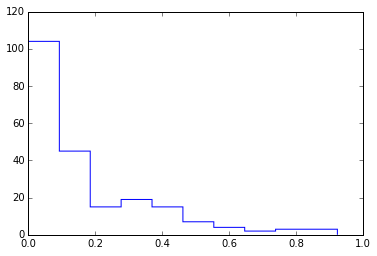

In [62]:
ents = [peptide.entropy for peptide in PDZ_Data.peptides]
plt.hist(ents, histtype='step')

# Comparison between Stiffler Model and Experimental Data 

In [14]:
binds = [peptide.y_manip_bind*74 for peptide in PDZ_Data.peptides]
model_binds = [peptide.y_model_bind*74 for peptide in PDZ_Data.peptides]
import matplotlib.pyplot as plt
%matplotlib inline

(array([ 133.,   16.,   15.,   12.,   15.,    7.,    4.,    3.,    2.,
           2.,    1.,    1.,    0.,    1.,    1.,    1.,    1.,    1.,
           0.,    1.]),
 array([ 11.1   ,  12.1125,  13.125 ,  14.1375,  15.15  ,  16.1625,
         17.175 ,  18.1875,  19.2   ,  20.2125,  21.225 ,  22.2375,
         23.25  ,  24.2625,  25.275 ,  26.2875,  27.3   ,  28.3125,
         29.325 ,  30.3375,  31.35  ]),
 <a list of 1 Patch objects>)

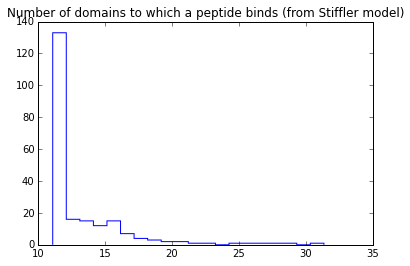

In [18]:
plt.title("Number of domains to which a peptide binds (from Stiffler model)") 
plt.hist(model_binds, bins = 20, histtype='step')

(array([ 104.,   29.,   16.,   15.,   12.,    7.,    8.,    7.,    4.,
           3.,    0.,    2.,    2.,    1.,    1.,    0.,    0.,    1.,
           1.,    1.,    1.,    0.,    1.,    0.,    1.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.]),
 <a list of 1 Patch objects>)

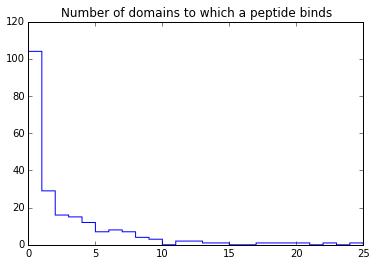

In [19]:
plt.title("Number of domains to which a peptide binds")
plt.hist(binds,bins=25, histtype='step')

# Calculate all relevant Peptide-Domain pair quantities

In [22]:
def eval_score(domain, sequence,pos=0):
    score = 0.0
    for i in range(5):
        score += domain.thetas[i,sequence[i]]
    return score - domain.thresholds[pos]
def sigmoid(x, a=1):
    return 1.0/(1+np.exp(-1.0*a*x))

In [37]:
for peptide in PDZ_Data.peptides:
    peptide.domain_data = {}
    for i in range(len(PDZ_Data.domain_names)):
        quant_list = []
        domain = PDZ_Data.domains[i]
        alpha = PDZ_Data.fp_interaction_matrix[peptide.name][i]
        if alpha > 0:
            quant_list.append(1.0)
        else:
            quant_list.append(alpha)
        energy = eval_score(domain, convert2int(peptide.sequence_bis),2)
        quant_list.append(energy) ## Score Calculated from Stiffler Model
        ## P(y_manip=1|seq) = P(y_manip=1|y_model = -1)*P(mod=-1|seq) + P(y_manip=1|y_model=1)*P(mod=1|seq)
        manip_1 = peptide.posterior_matrix[1,0]*sigmoid(energy,-1) + peptide.posterior_matrix[1,1]*sigmoid(energy) 
        ## P(y_manip=-1|seq) = P(y_manip=-1|y_model = -1)*P(mod=-1|seq) + P(y_manip=-1|y_model=1)*P(mod=1|seq)
        manip_0 = peptide.posterior_matrix[0,0]*sigmoid(energy,-1) + peptide.posterior_matrix[0,1]*sigmoid(energy)
        quant_list.append(manip_1)
        quant_list.append(manip_0)
        peptide.domain_data[domain.name] = quant_list 

In [38]:
test_peptide = PDZ_Data.peptides[56]
print test_peptide.y_manip_bind*74

6.0


# Divide the peptides according to the number of domains they bind to

In [41]:
from collections import OrderedDict
peptide_dist = OrderedDict()
for value in binds:
    peptide_dist[value] = []

In [43]:
for peptide in PDZ_Data.peptides:
    x = peptide.y_manip_bind*74
    peptide_dist[x].append(peptide)

# Analysis of peptides with binding number = 0

In [76]:
zeros = peptide_dist[0.0]

In [77]:
updated_binding_probs = []
for peptide in zeros:
    for domain in PDZ_Data.domain_names:
        quant_list = peptide.domain_data[domain]
        updated_binding_probs.append(quant_list[2])
        

(array([    0.,     0.,     0.,     0.,     0.,  7696.,     0.,     0.,
            0.,     0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

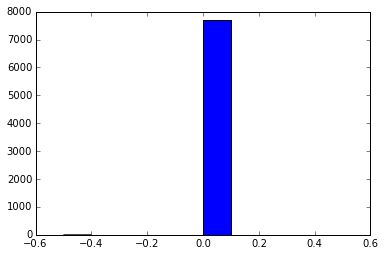

In [78]:
plt.hist(updated_binding_probs)

# Binding number = 1

In [79]:
bn_1 = peptide_dist[1.0]

## Calculate updated Binding probabilities 


In [202]:
for peptide in PDZ_Data.peptides:
    
    peptide.energies = [eval_score(domain, convert2int(peptide.sequence_bis),0) for domain in PDZ_Data.domains]
    peptide.upd_bind_prob= [peptide.posterior_matrix[1,0]*sigmoid(energy,-1) + peptide.posterior_matrix[1,1]*sigmoid(energy) for energy in peptide.energies]
    true_interactions = []
    for i in range(len(PDZ_Data.domains)):
        if PDZ_Data.fp_interaction_matrix[peptide.name][i] >0:
            true_interactions.append(peptide.upd_bind_prob[i])
    if len(true_interactions) == 0:
        peptide.lower_prob = 0
    else:
        peptide.lower_prob = np.min(true_interactions)

In [203]:
ix = PDZ_Data.pep_names.index('Kv1.7')
pep_demo = PDZ_Data.peptides[ix]

In [148]:
true_binding_probs = []
false_binding_probs = []
for peptide in bn_1:
    for domain in PDZ_Data.domain_names:
        quant_list = peptide.domain_data[domain]
        if quant_list[0] == 1.0:
            true_binding_probs.append(quant_list[2])
        else:
            false_binding_probs.append(quant_list[2])
            
    

(array([  2.,   1.,   0.,   0.,   2.,   3.,   0.,   1.,   0.,  20.]),
 array([ 0.00064423,  0.00864026,  0.01663629,  0.02463232,  0.03262835,
         0.04062438,  0.04862041,  0.05661644,  0.06461247,  0.0726085 ,
         0.08060453]),
 <a list of 10 Patch objects>)

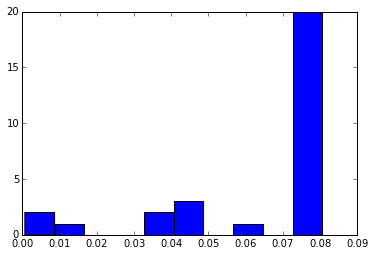

In [149]:
plt.hist(true_binding_probs)

In [150]:
print np.max(false_binding_probs)

0.0806044923742


In [151]:
print np.max(true_binding_probs)

0.080604534005


In [152]:
def analyse_bn(bn):
    bn_x = peptide_dist[bn]
    true_binding_probs = []
    false_binding_probs = []
    for peptide in bn_x:
        for domain in PDZ_Data.domain_names:
            quant_list = peptide.domain_data[domain]
            if quant_list[0] == 1.0:
                true_binding_probs.append(quant_list[2])
            else:
                false_binding_probs.append(quant_list[2])
    if len(true_binding_probs) == 0.0:
        return (0,1)
    else:
        return (np.min(true_binding_probs), np.max(false_binding_probs))


In [153]:
b_probs_true = []
b_probs_false = []
for item in peptide_dist.keys():
    x = analyse_bn(item)
    b_probs_true.append(x[0])
    b_probs_false.append(x[1])

In [154]:
analyse_bn(2.0)

(0.0013054910657454523, 0.15094102037024454)

In [155]:
for i in range(len(b_probs_true)):
    print "{} {} {}".format(peptide_dist.keys()[i],b_probs_true[i], b_probs_false[i])

1.0 0.000644226128669 0.0806044923742
0.0 0 1
2.0 0.00130549106575 0.15094102037
5.0 0.00349901441692 0.316222167265
17.0 0.0175945457191 0.186568418391
3.0 0.00198445510172 0.212858311804
25.0 0.033248233053 0.115094486815
12.0 0.0604727075131 0.279318123404
6.0 0.00413508292052 0.318888779436
8.0 0.00570926644683 0.276865233072
11.0 0.0405547776512 0.515584442591
7.0 0.00610879785965 0.399333690325
9.0 0.00668384070647 0.4321776578
4.0 0.00268186392889 0.267760339955
14.0 0.0108611326622 0.247153148886
19.0 0.157739896044 0.675379043907
20.0 0.161927450436 0.702561084288
22.0 0.0196002814793 0.0377810160701
18.0 0.0149023904359 0.636094741095
13.0 0.0322930606742 0.536871734362


# Error Prone Domains 

In [187]:
ix = PDZ_Data.pep_names.index('Kv1.7')
pep_demo = PDZ_Data.peptides[ix]
energies = [eval_score(domain, convert2int(pep_demo.sequence_bis),2) for domain in PDZ_Data.domains]
print pep_demo.posterior_matrix
print pep_demo.y_manip_bind*74
for i in range(len(energies)):
    print "{}\t {}\t {}\t".format(PDZ_Data.domains[i].name, energies[i], PDZ_Data.fp_interaction_matrix[pep_demo.name][i])

[[ 0.99007065  0.42302358]
 [ 0.00992935  0.57697642]]
13.0
Cipp (03/10)	 -8.14647	 -1.0	
Cipp (05/10)	 -19.60901	 -1.0	
Cipp (08/10)	 12.1962	 17896.25943	
Cipp (09/10)	 -8.94231	 -1.0	
Cipp (10/10)	 -1.98574	 -1.0	
D930005D10Rik (1/1)	 -6.81225	 -1.0	
Dlgh3 (1/1)	 -10.89372	 -1.0	
Dvl1 (1/1)	 -10.82181	 -1.0	
Dvl2 (1/1)	 -10.33306	 -1.0	
Dvl3 (1/1)	 -8.65079	 -1.0	
Erbin (1/1)	 -5.366669	 -1.0	
Gm1582 (2/3)	 6.7366	 25720.02273	
GRASP55 (1/1)	 -9.33836	 -1.0	
Grip1 (6/7)	 -19.56178	 -1.0	
Grip2 (5/7)	 7.38578	 12536.37452	
Harmonin (2/3)	 -7.97413	 -1.0	
HtrA1 (1/1)	 28.55	 3788.65461	
HtrA3 (1/1)	 -23.0333	 -1.0	
Interleukin 16 (1/4)	 -10.85698	 -1.0	
LARG (1/1)	 5.94835	 12057.93739	
LIN-7A (1/1)	 -6.95096	 -1.0	
Lin7c (1/1)	 -18.44157	 -1.0	
Lnx1 (2/4)	 -4.85857	 -1.0	
Lrrc7 (1/1)	 -7.11262	 -1.0	
Magi-1 (2/6)	 2.575598	 -1.0	
Magi-1 (4/6)	 -7.903327	 -1.0	
Magi-1 (6/6)	 -11.58425	 -1.0	
Magi-2 (5/6)	 -5.47664	 -1.0	
Magi-2 (6/6)	 6.8568	 79666.25935	
Magi-3 (2/5)	 -2.99999999989e

(array([  1.,   1.,   0.,   0.,   0.,   1.,   1.,   3.,   3.,  10.,  12.,
         19.,   5.,   5.,   5.,   2.,   2.,   2.,   1.,   0.,   0.,   0.,
          0.,   0.,   1.]),
 array([-39.2495 , -36.53752, -33.82554, -31.11356, -28.40158, -25.6896 ,
        -22.97762, -20.26564, -17.55366, -14.84168, -12.1297 ,  -9.41772,
         -6.70574,  -3.99376,  -1.28178,   1.4302 ,   4.14218,   6.85416,
          9.56614,  12.27812,  14.9901 ,  17.70208,  20.41406,  23.12604,
         25.83802,  28.55   ]),
 <a list of 1 Patch objects>)

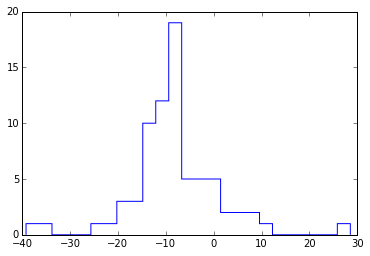

In [188]:
plt.hist(energies, bins=25, histtype='step')

In [191]:
for i in range(len(pep_demo.upd_bind_prob)):
    print "{}\t {}\t {}\t".format(PDZ_Data.domain_names[i], pep_demo.upd_bind_prob[i], PDZ_Data.fp_interaction_matrix[pep_demo.name][i])

Cipp (03/10)	 0.0100936067855	 -1.0	
Cipp (05/10)	 0.00992961970769	 -1.0	
Cipp (08/10)	 0.576976383314	 17896.25943	
Cipp (09/10)	 0.0102412659416	 -1.0	
Cipp (10/10)	 0.0947308661773	 -1.0	
D930005D10Rik (1/1)	 0.0105525367089	 -1.0	
Dlgh3 (1/1)	 0.0099398812934	 -1.0	
Dvl1 (1/1)	 0.0099427382724	 -1.0	
Dvl2 (1/1)	 0.00994779961461	 -1.0	
Dvl3 (1/1)	 0.0104275125406	 -1.0	
Erbin (1/1)	 0.0125649585364	 -1.0	
Gm1582 (2/3)	 0.576951980821	 25720.02273	
GRASP55 (1/1)	 0.0100015900402	 -1.0	
Grip1 (6/7)	 0.00992935067539	 -1.0	
Grip2 (5/7)	 0.576953037068	 12536.37452	
Harmonin (2/3)	 0.010124490065	 -1.0	
HtrA1 (1/1)	 0.576976421637	 3788.65461	
HtrA3 (1/1)	 0.0166748458358	 -1.0	
Interleukin 16 (1/4)	 0.00996546912286	 -1.0	
LARG (1/1)	 0.575706126056	 12057.93739	
LIN-7A (1/1)	 0.0106187484743	 -1.0	
Lin7c (1/1)	 0.00992937167576	 -1.0	
Lnx1 (2/4)	 0.0184629272544	 -1.0	
Lrrc7 (1/1)	 0.0104216098866	 -1.0	
Magi-1 (2/6)	 0.536871734362	 -1.0	
Magi-1 (4/6)	 0.0101388022379	 -1.0	
Magi-1

In [192]:
count = 0
for i in range(len(pep_demo.upd_bind_prob)):
    if (pep_demo.upd_bind_prob[i] > pep_demo.lower_prob) & (PDZ_Data.fp_interaction_matrix[pep_demo.name][i] < 0):
        count +=1
        print "{}\t {}\t {}\t".format(PDZ_Data.domain_names[i], pep_demo.upd_bind_prob[i], PDZ_Data.fp_interaction_matrix[pep_demo.name][i])
print count

Magi-1 (2/6)	 0.536871734362	 -1.0	
Magi-3 (5/5)	 0.276403211452	 -1.0	
Shank1 (1/1)	 0.568194078226	 -1.0	
3


In [210]:
for peptide in PDZ_Data.peptides:
    peptide.domain_incorrect = []
    for i in range(len(peptide.upd_bind_prob)):
        if (peptide.upd_bind_prob[i] >  peptide.lower_prob) & (PDZ_Data.fp_interaction_matrix[peptide.name][i] <0):
            peptide.domain_incorrect.append(PDZ_Data.domain_names[i])
            

In [194]:
pep_demo.posterior_matrix

array([[ 0.99007065,  0.42302358],
       [ 0.00992935,  0.57697642]])

In [176]:
for peptide in PDZ_Data.peptides:
    peptide.out_domains = []
    peptide.false_count = 0
    for i in range(len(peptide.upd_bind_prob)):
        if (peptide.upd_bind_prob[i] > peptide.lower_prob) & (PDZ_Data.fp_interaction_matrix[peptide.name][i] < 0):
            peptide.out_domains.append(PDZ_Data.domain_names[i])
            peptide.false_count +=1

(array([ 45.,   9.,   9.,   1.,   7.,   2.,   0.,   0.,   0.,   1.]),
 array([  1. ,   4.2,   7.4,  10.6,  13.8,  17. ,  20.2,  23.4,  26.6,
         29.8,  33. ]),
 <a list of 1 Patch objects>)

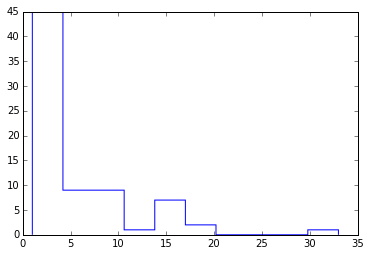

In [218]:
from collections import OrderedDict
freq_count = {domain:0 for domain in PDZ_Data.domain_names}
for peptide in PDZ_Data.peptides:
    for domain in PDZ_Data.domain_names:
        if domain in peptide.out_domains:
            freq_count[domain] +=1
count = list(freq_count.viewvalues())
plt.hist(count, histtype='step')

In [205]:
for peptide in PDZ_Data.peptides:
    print "{}\t {}\t {}".format(peptide.name, peptide.y_manip_bind*74, peptide.false_count)

AN2	 1.0	 1
APC	 0.0	 0
Aquaporin4	 2.0	 1
ASIC2	 0.0	 0
Caspr2	 5.0	 4
Cav2.2	 0.0	 0
Cftr	 17.0	 5
c-KIT	 0.0	 0
Claudin1	 3.0	 0
Cnksr2	 25.0	 2
Connexin43	 1.0	 2
CRIPT	 12.0	 3
CtBP1	 0.0	 0
Dlgap123	 6.0	 2
EphA71	 8.0	 0
EphB2	 1.0	 0
EphrinB12	 1.0	 0
ErbB4	 1.0	 0
Frizzled	 11.0	 5
GluR1	 2.0	 0
GluR2_1	 1.0	 0
GluR5_1	 1.0	 0
GlycphrinC	 1.0	 1
GRK6	 5.0	 3
Htr2c	 7.0	 2
JAM-1	 2.0	 0
KIF17	 2.0	 2
KIF1B	 11.0	 2
Kir2.1	 2.0	 7
Kv1.4	 9.0	 9
Lgltminase	 5.0	 0
Liprin2	 0.0	 0
Megalin	 4.0	 7
Mel1a/b	 4.0	 1
mGluR3	 1.0	 1
ctransprtr	 8.0	 1
Nav1.4	 14.0	 5
Nav1.5	 9.0	 8
Neurxin1/2	 5.0	 5
NMDAR2A	 7.0	 5
NMDAR2B	 8.0	 5
P2Y1	 4.0	 7
Parkin	 3.0	 0
PDGFR	 1.0	 1
PFK-M	 0.0	 0
PIX	 7.0	 8
PKC	 8.0	 3
PMCA1	 19.0	 5
Ril	 4.0	 6
Sapk3	 20.0	 4
SSTR2	 22.0	 2
Stargazin	 1.0	 2
Syndecan1	 1.0	 0
Syndecan2	 1.0	 0
TAZ	 18.0	 4
Trip6	 0.0	 0
TRPC4	 6.0	 2
AcvR1	 0.0	 0
AcvR2	 5.0	 3
AcvR2b	 3.0	 2
Cacna1a	 1.0	 0
Cav1.2	 3.0	 2
Cav2.3	 0.0	 0
Cav3.2	 0.0	 0
ITPR3	 0.0	 0
RYR2	 0.0	 

In [212]:
for peptide in PDZ_Data.peptides:
    print "{}\t  {}".format(peptide.name, peptide.domain_incorrect)

AN2	  ['HtrA3 (1/1)']
APC	  []
Aquaporin4	  ['Cipp (08/10)']
ASIC2	  []
Caspr2	  ['Cipp (05/10)', 'HtrA1 (1/1)', 'Interleukin 16 (1/4)', 'PDZ-RGS3 (1/1)']
Cav2.2	  []
Cftr	  ['NHERF-2 (2/2)', 'PSD95 (1/3)', 'SAP97 (3/3)', 'SAP102 (3/3)', 'a1-syntrophin (1/1)']
c-KIT	  []
Claudin1	  []
Cnksr2	  ['Shank3 (1/1)', 'a1-syntrophin (1/1)']
Connexin43	  ['Grip2 (5/7)', 'Pdzk11 (1/1)']
CRIPT	  ['Cipp (08/10)', 'Pdzk1 (1/4)', 'Shank1 (1/1)']
CtBP1	  []
Dlgap123	  ['PDZ-RGS3 (1/1)', 'Scrb1 (3/4)']
EphA71	  []
EphB2	  []
EphrinB12	  []
ErbB4	  []
Frizzled	  ['LIN-7A (1/1)', 'Semcap3 (1/2)', 'Shank1 (1/1)', 'Shank3 (1/1)', 'a1-syntrophin (1/1)']
GluR1	  []
GluR2_1	  []
GluR5_1	  []
GlycphrinC	  ['HtrA3 (1/1)']
GRK6	  ['NHERF-2 (2/2)', 'Pdzk1 (1/4)', 'PDZ-RGS3 (1/1)']
Htr2c	  ['HtrA3 (1/1)', 'MUPP1 (10/13)']
JAM-1	  []
KIF17	  ['NHERF-2 (2/2)', 'Pdzk11 (1/1)']
KIF1B	  ['Gm1582 (2/3)', 'Shank1 (1/1)']
Kir2.1	  ['Gm1582 (2/3)', 'HtrA1 (1/1)', 'Magi-3 (5/5)', 'Pdzk3 (1/1)', 'PTP-BL (2/5)', 'a1-syntroph

In [369]:
freq_count

{'Cipp (03/10)': 1,
 'Cipp (05/10)': 2,
 'Cipp (08/10)': 16,
 'Cipp (09/10)': 1,
 'Cipp (10/10)': 1,
 'D930005D10Rik (1/1)': 2,
 'Dlgh3 (1/1)': 1,
 'Dvl1 (1/1)': 1,
 'Dvl2 (1/1)': 1,
 'Dvl3 (1/1)': 2,
 'Erbin (1/1)': 5,
 'GRASP55 (1/1)': 2,
 'Gm1582 (2/3)': 14,
 'Grip1 (6/7)': 1,
 'Grip2 (5/7)': 10,
 'Harmonin (2/3)': 1,
 'HtrA1 (1/1)': 33,
 'HtrA3 (1/1)': 11,
 'Interleukin 16 (1/4)': 6,
 'LARG (1/1)': 4,
 'LIN-7A (1/1)': 4,
 'Lin7c (1/1)': 2,
 'Lnx1 (2/4)': 5,
 'Lrrc7 (1/1)': 2,
 'MUPP1 (01/13)': 1,
 'MUPP1 (05/13)': 1,
 'MUPP1 (10/13)': 6,
 'MUPP1 (11/13)': 1,
 'MUPP1 (12/13)': 1,
 'MUPP1 (13/13)': 2,
 'Magi-1 (2/6)': 3,
 'Magi-1 (4/6)': 2,
 'Magi-1 (6/6)': 2,
 'Magi-2 (5/6)': 6,
 'Magi-2 (6/6)': 9,
 'Magi-3 (2/5)': 2,
 'Magi-3 (5/5)': 8,
 'Mpp7 (1/1)': 1,
 'NHERF-1 (1/2)': 2,
 'NHERF-2 (2/2)': 15,
 'PAR-3 (3/3)': 1,
 'PAR3B (1/3)': 2,
 'PAR6B (1/1)': 1,
 'PDZ-RGS3 (1/1)': 16,
 'PSD95 (1/3)': 14,
 'PTP-BL (2/5)': 8,
 'Pdlim5 (1/1)': 1,
 'Pdzk1 (1/4)': 8,
 'Pdzk1 (3/4)': 1,
 'Pdzk11 (

In [389]:
apc = peptide_dist[1.0][0]
print apc.posterior_matrix
print apc.entropy
print apc.energy_ground
print apc.upd_bind_prob


[[  9.99355774e-01   9.19395466e-01]
 [  6.44226123e-04   8.06045340e-02]]
0.103275084572
3.21413650144
[0.002812326255055589, 0.076896905150057607, 0.022249629006199624, 0.001161337117703569, 0.00067198535388700244, 0.0009955831279796698, 0.00067722629778975061, 0.017326124327010681, 0.00080261683007915659, 0.078703499056731754, 0.0016018907024254281, 0.00066808096645204506, 0.00064458856969097926, 0.000644240593415555, 0.032493250196710594, 0.0045474073673390392, 0.080430889238527245, 0.080603826650455027, 0.00083578727011311975, 0.00068280107315124485, 0.00065386934292528101, 0.0006442261233766428, 0.066409035783704232, 0.00065213231938346708, 0.0007406415407852498, 0.00073155602120874826, 0.00064422742133851891, 0.0014390107519963566, 0.00064861349692057883, 0.00064651299329653608, 0.00064422614848005661, 0.00072664334214896521, 0.0025763881667934252, 0.0016665845021776172, 0.011495340369360197, 0.00065985493582175145, 0.00064500592234707375, 0.00064787026215102597, 0.0006442706136

# Simulations 

In [234]:
def log_modified(x):
    if x > 0:
        return np.log(1+np.exp(-x))
    else:
        return -x + np.log(1+np.exp(x))

In [242]:
def calc_log_proba_mod(peptide, domain, sequence):
    ix = PDZ_Data.domain_names.index(domain.name)
    alpha = PDZ_Data.fp_interaction_matrix[peptide.name][ix]
    score = eval_score(domain, sequence,0)
    if alpha > 0:
        a = peptide.posterior_matrix[1,1]
        z_1 = log_modified(score)
        x = np.log(a) - z_1
        b = peptide.posterior_matrix[1,0]
        z_2 = log_modified(-1.0*score)
        y = np.log(b)-z_2
        result = np.logaddexp(x,y)        
    else:
        a = peptide.posterior_matrix[0,1]
        z_1 = log_modified(score)
        x = np.log(a) - z_1
        b = peptide.posterior_matrix[0,0]
        z_2 = log_modified(-1.0*score)
        y = np.log(b)-z_2
        result = np.logaddexp(x,y)
    return result*-1.0

In [257]:
def eval_log_energy(peptide, sequence):
    en = 0.0
    for domain in PDZ_Data.domains:
        en += calc_log_proba_mod(peptide, domain, sequence)
    return en

In [269]:
for peptide in PDZ_Data.peptides:
    peptide.energy_ground = eval_log_energy(peptide, convert2int(peptide.sequence_bis))

(array([ 104.,   27.,   22.,   22.,   17.,   11.,   10.,    2.,    1.,    1.]),
 array([ -1.28138484e-15,   2.03470673e+00,   4.06941347e+00,
          6.10412020e+00,   8.13882693e+00,   1.01735337e+01,
          1.22082404e+01,   1.42429471e+01,   1.62776539e+01,
          1.83123606e+01,   2.03470673e+01]),
 <a list of 10 Patch objects>)

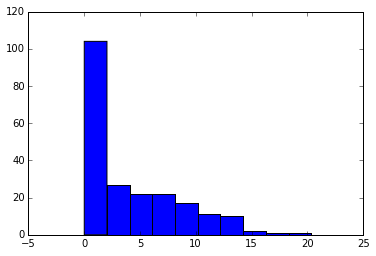

In [270]:
plt.hist(grounds)

In [472]:
def run_mc(nb_runs, peptide,beta = 1.0, nb_cycles=10, plot=False, verbose=True, print_reject = False):
    import matplotlib.pyplot as plt
    sims = []
    print "Name of Peptide {}".format(peptide.name)
    print "Base Energy {}".format(peptide.energy_ground)
    print "Base Sequence {}".format(peptide.sequence_bis)
    base_seq = convert2int(peptide.sequence_bis)
    peptide.mutations = []
    for j in range (nb_cycles):
        print "\n Cycle number : {}\n".format(j+1)
        sim_results = []
        mutated_sequences = []
        mutated_energies = []
        for_plot = []
        sequences_accepted = []
        mut_seq = base_seq
        mut_energy = peptide.energy_ground
        for i in range(nb_runs):
            y = np.random.randint(5)
            z = np.random.randint(19)
            ## Remove if the amino acid change is the same as before 
            if z >= mut_seq[y]:
                z = z+1                
            temp_seq = mut_seq[:]
            #print "Last sequence seen {}".format(convert2seq(mut_seq))
            temp_seq[y] = z
            #print "Sequence after mutation {}\n".format(convert2seq(temp_seq))
            temp_energy = eval_log_energy(peptide, temp_seq)
            ratio = np.exp(-beta*(temp_energy-mut_energy))
            prob_trans = min(1, ratio)
            x = np.random.uniform()
            if x < prob_trans:
                mut_energy = temp_energy
                mut_seq = temp_seq
                if verbose:
                    print "Run number: {}\n".format(i)
                    print "Uniform {} Ratio {} Prob_Trans {} ".format(x,ratio,prob_trans)
                    print "Accepted {} {} {} {} \n".format(temp_seq, temp_energy, convert2seq(temp_seq), convert2seq(mut_seq))
                sim_results.append({'Sequence': temp_seq, 'Energy': temp_energy, 'Status': 'Accepted'})
                for_plot.append(temp_energy)
            else:
                if verbose: 
                    if print_reject:                        
                        print "Run number: {}\n".format(i)
                        print "Uniform {} Ratio {} Prob_Trans {} ".format(x,ratio,prob_trans)
                        print "Rejected {} {} {} {}\n".format(temp_seq, temp_energy, convert2seq(temp_seq), convert2seq(mut_seq))
                sim_results.append({'Sequence': temp_seq, 'Energy': temp_energy, 'Status': 'Rejected'})  

                ##print "Rejected {} {}".format(temp_seq, temp_energy)
            mutated_sequences.append(temp_seq)
            mutated_energies.append(temp_energy)
        peptide.mutations.append(sequences_accepted)
        print "Lowest Energy {} Sequence {}\n".format(np.min(mutated_energies), convert2seq(mutated_sequences[np.argmin(mutated_energies)]))
        if plot == True:
            plt.figure(j)            
            plt.axhline(y = peptide.energy_ground, hold = None, c = 'r', linewidth=0.5)
            if len(for_plot) == 1:
                plt.axhline(y = for_plot[0], hold=None, c = 'b', linewidth = 1.5)
            plt.plot(for_plot)
            plt.show()
        sims.append({'Results' : sim_results, 'Mutated sequences': mutated_sequences, 'Mutated Energies': mutated_energies}) 
    peptide.sims = sims
    print " Completed run for {}\n".format(peptide.name)

In [296]:
def compute_unique_mut(peptide):
    unique = []
    for run in peptide.mutations:
        for item in run:
            if item not in unique:
                unique.append(item)
    return unique 

In [447]:
def compute_freq_matrix(pep):
    freq_matrix = np.zeros((5,20))
    accepted = []
    for i in range(len(pep.sims)):
        temp1 = pep.sims[i]['Results']
        for j in range(len(temp1)):
            if temp1[j]['Status'] == 'Accepted':
                accepted.append(temp1[j]['Sequence'])
    for mut in accepted:
        for i in range(5):
            freq_matrix[i,mut[i]] +=1
    freq_matrix_normalized = freq_matrix.astype('float') / freq_matrix.sum(axis=1)[:, np.newaxis]
    return [freq_matrix, freq_matrix_normalized]
def compute_proba_pos(pep,pos):
    return 1-compute_freq_matrix(pep)[1][pos,convert2int(pep.sequence_bis)[pos]]

def plot_freq_matrix(pep, normalized = True):
    if normalized:
        fm_normalized = compute_freq_matrix(pep)[1]
    else:
        fm_normalized = compute_freq_matrix(pep)[0]
    print "Sequence of Peptide {}".format(pep.sequence_bis)
    plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.title("Frequency matrix for Peptide {}".format(pep.name))
    plt.xticks(range(len(PDZ_Data.aminoacids)), PDZ_Data.aminoacids, fontsize=12)
    plt.imshow(fm_normalized,interpolation='nearest', cmap = plt.cm.Blues)
    plt.colorbar()

acid_names = ['Glycine', 'Alanine', 'Valine', 'Leucine', 'Isoleucine', 'Methionine', 'Proline', 'Phenylalanine', 'Tryptophan', 'Serine', \
              'Threonine', 'Asparagine', 'Glutamine', 'Tyrosine', 'Cysteine', 'Lysine', 'Arginine', 'Histidine', 'Aspartate', 'Glutamate']
acid_dict = {PDZ_Data.aminoacids[i]:acid_names[i] for i in range(len(PDZ_Data.aminoacids))}
def print_seq(pep):
    for acid in pep.sequence_bis:
        print "{} {} ".format(acid,acid_dict[acid])

In [678]:
bn = 7.0
print len(peptide_dist[bn])

7


In [682]:
test_peptide = peptide_dist[bn][0]
print peptide_dist[bn][1].name
print peptide_dist[bn][1].sequence_bis
print peptide_dist[bn][1].energy_ground
print test_peptide.sequence_bis
#ix = PDZ_Data.pep_names.index('Cftr')
#test_peptide = PDZ_Data.peptides[ix]
print test_peptide.name
print test_peptide.energy_ground
print test_peptide.y_manip_bind*74
print test_peptide.entropy
for peptide in peptide_dist[bn]:
    print peptide.sequence_bis

NMDAR2A
['I', 'E', 'S', 'D', 'V']
10.9113403009
['R', 'I', 'S', 'S', 'V']
Htr2c
8.13818772747
7.0
0.451622822182
['R', 'I', 'S', 'S', 'V']
['I', 'E', 'S', 'D', 'V']
['D', 'E', 'T', 'N', 'L']
['R', 'K', 'D', 'Y', 'V']
['K', 'S', 'Q', 'Y', 'V']
['K', 'E', 'Y', 'F', 'F']
['R', 'E', 'T', 'D', 'L']


Name of Peptide Htr2c
Base Energy 8.13818772747
Base Sequence ['R', 'I', 'S', 'S', 'V']

 Cycle number : 1

Run number: 9

Uniform 0.559095548039 Ratio 0.847168729508 Prob_Trans 0.847168729508 
Accepted [16, 4, 9, 9, 3] 8.30404312325 ['R', 'I', 'S', 'S', 'L'] ['R', 'I', 'S', 'S', 'L'] 

Run number: 14

Uniform 0.561344839554 Ratio 1.18040239821 Prob_Trans 1 
Accepted [16, 4, 9, 9, 2] 8.13818772747 ['R', 'I', 'S', 'S', 'V'] ['R', 'I', 'S', 'S', 'V'] 

Run number: 16

Uniform 0.0451893532962 Ratio 0.532681762896 Prob_Trans 0.532681762896 
Accepted [11, 4, 9, 9, 2] 8.76801882834 ['N', 'I', 'S', 'S', 'V'] ['N', 'I', 'S', 'S', 'V'] 

Run number: 18

Uniform 0.154132811984 Ratio 0.46278117935 Prob_Trans 0.46278117935 
Accepted [8, 4, 9, 9, 2] 9.53851977975 ['W', 'I', 'S', 'S', 'V'] ['W', 'I', 'S', 'S', 'V'] 

Run number: 19

Uniform 0.126375709233 Ratio 2.68278198695 Prob_Trans 1 
Accepted [6, 4, 9, 9, 2] 8.5516654688 ['P', 'I', 'S', 'S', 'V'] ['P', 'I', 'S', 'S', 'V'] 

Run number: 24

Unif

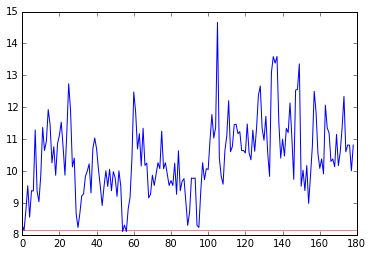

 Completed run for Htr2c



In [680]:
run_mc(1000, test_peptide,beta=1.00, nb_cycles = 1, plot = True, verbose=True, print_reject=False)

R Arginine 
I Isoleucine 
S Serine 
S Serine 
V Valine 
Sequence of Peptide ['R', 'I', 'S', 'S', 'V']


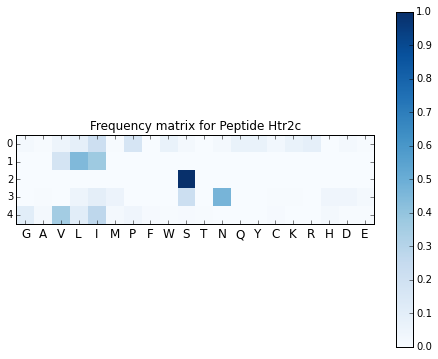

In [683]:
print_seq(test_peptide)
plot_freq_matrix(test_peptide, normalized=True)

# Calculate entropy  

In [617]:
def compute_entropy_sequence(peptide):
    test_matrix = compute_freq_matrix(test_peptide)[1]
    entropy_sequence = []
    x,y = test_matrix.shape
    for i in range(x):
        w = 0.0
        for j in range(y):
            if test_matrix[i][j] == 0:
                w += 0
            else:
                w += test_matrix[i][j] * np.log(test_matrix[i][j])
        w = -1.0*w
        entropy_sequence.append(w)
    peptide.entropy_sequence = entropy_sequence
    return entropy_sequence            

In [684]:
print compute_entropy_sequence(test_peptide)

[2.4289121008121035, 1.0355417546525065, -0.0, 1.6311199218765353, 1.8302749732570978]


# Average Energy variation wrt temperature

In [604]:
def compute_accepted_energies(peptide):
    temp1 = peptide.sims[0]['Results']

    accepted = []
    for j in range(len(temp1)):
        if temp1[j]['Status'] == 'Accepted':
            accepted.append(temp1[j]['Energy'])
    return accepted

(array([  1.,   5.,   9.,  15.,  25.,  14.,  13.,   4.,   3.,   3.]),
 array([ 13.03158599,  14.11260986,  15.19363372,  16.27465758,
         17.35568144,  18.4367053 ,  19.51772916,  20.59875302,
         21.67977688,  22.76080074,  23.8418246 ]),
 <a list of 10 Patch objects>)

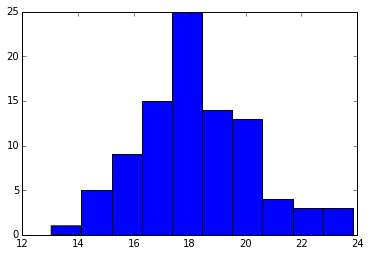

In [674]:
plt.hist(compute_accepted_energies(test_peptide))

In [685]:
def average_temperature(peptide, temp_range):
    average_energies = []
    entropies = []
    for i in range(len(temp_range)):
        print "{}\t {}".format('Beta' , temp_range[i])
        run_mc(1000, peptide, nb_cycles= 1, beta = temp_range[i], print_reject=False, verbose=False, plot=True)
        accepted_energies = compute_accepted_energies(peptide)
        average_energies.append(np.average(accepted_energies))
        entropies.append(compute_entropy_sequence(peptide))
    return average_energies, entropies
        

Beta	 0.0
Name of Peptide Htr2c
Base Energy 8.13818772747
Base Sequence ['R', 'I', 'S', 'S', 'V']

 Cycle number : 1

Lowest Energy 8.56109216433 Sequence ['K', 'I', 'S', 'S', 'V']



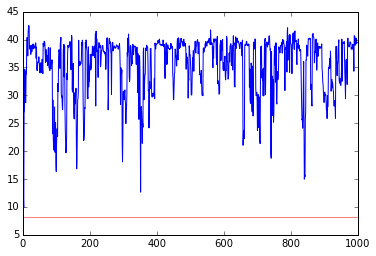

 Completed run for Htr2c

Beta	 1.0
Name of Peptide Htr2c
Base Energy 8.13818772747
Base Sequence ['R', 'I', 'S', 'S', 'V']

 Cycle number : 1

Lowest Energy 8.10181627933 Sequence ['R', 'I', 'S', 'S', 'I']



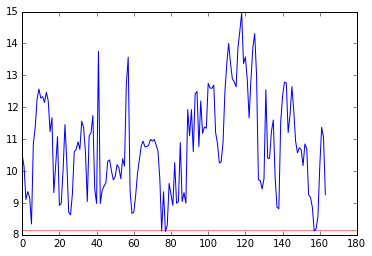

 Completed run for Htr2c

Beta	 2.0
Name of Peptide Htr2c
Base Energy 8.13818772747
Base Sequence ['R', 'I', 'S', 'S', 'V']

 Cycle number : 1

Lowest Energy 8.10181627933 Sequence ['R', 'I', 'S', 'S', 'I']



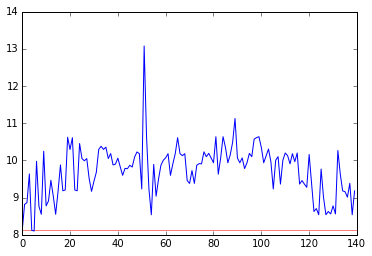

 Completed run for Htr2c

Beta	 3.0
Name of Peptide Htr2c
Base Energy 8.13818772747
Base Sequence ['R', 'I', 'S', 'S', 'V']

 Cycle number : 1

Lowest Energy 8.10181627933 Sequence ['R', 'I', 'S', 'S', 'I']



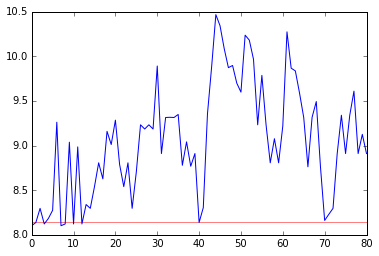

 Completed run for Htr2c

Beta	 4.0
Name of Peptide Htr2c
Base Energy 8.13818772747
Base Sequence ['R', 'I', 'S', 'S', 'V']

 Cycle number : 1

Lowest Energy 8.10181627933 Sequence ['R', 'I', 'S', 'S', 'I']



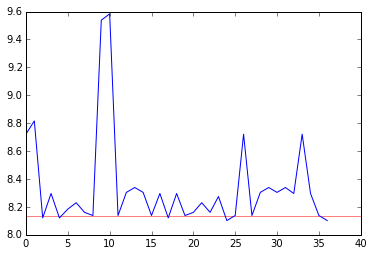

 Completed run for Htr2c



In [686]:
average_energies, entropies = average_temperature(test_peptide, np.arange(0.0, 5, 1))

In [687]:
len(average_energies)

5

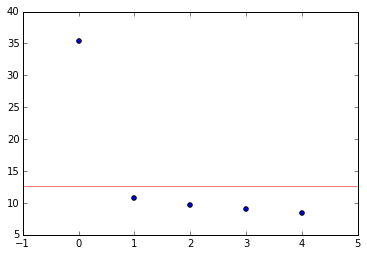

In [689]:
plt.scatter(np.asarray(np.arange(0.0, 5, 1)), np.asarray(average_energies))
plt.axhline(y = peptide.energy_ground, hold = None, c = 'r', linewidth=0.5)

# Entropy of the sequences

In [458]:
def compute_entropy(pep):
    from collections import OrderedDict
    seq_count_bis = OrderedDict()
    sequences = pep.sims[0]['Mutated sequences']
    for seq in sequences:
        if tuple(seq) not in seq_count_bis:
            seq_count_bis[tuple(seq)] = 1
        else:
            seq_count_bis[tuple(seq)] +=1 
    ent = 0.0
    for key,value in seq_count_bis.items():
        ent += value*np.log(value)
    ent = ent/len(sequences) - np.log(len(sequences))
    return -1.0*ent

In [675]:
print compute_entropy(test_peptide)
print test_peptide.entropy


6.38612281612
0.639457132485


Name of Peptide AN2
Base Energy 3.21413650144
Base Sequence ['G', 'Q', 'Y', 'W', 'V']

 Cycle number : 1

Lowest Energy 2.64696242913 Sequence ['K', 'W', 'H', 'T', 'H']



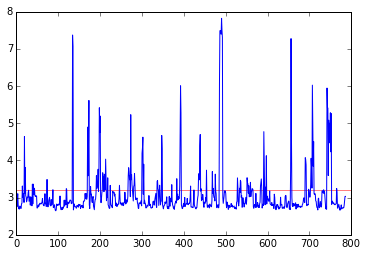

 Completed run for AN2

Name of Peptide APC
Base Energy -7.12237513027e-16
Base Sequence ['L', 'V', 'T', 'S', 'V']

 Cycle number : 1

Lowest Energy -1.6217870918e-15 Sequence ['I', 'P', 'K', 'N', 'Y']



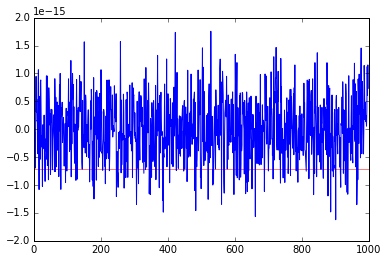

 Completed run for APC

Name of Peptide Aquaporin4
Base Energy 4.9054347853
Base Sequence ['V', 'L', 'S', 'S', 'V']

 Cycle number : 1

Lowest Energy 4.21385990714 Sequence ['I', 'Q', 'C', 'M', 'P']



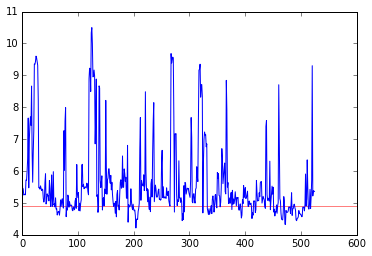

 Completed run for Aquaporin4

Name of Peptide Caspr2
Base Energy 10.0034831294
Base Sequence ['K', 'E', 'W', 'L', 'I']

 Cycle number : 1

Lowest Energy 7.51996992568 Sequence ['K', 'P', 'W', 'L', 'Q']



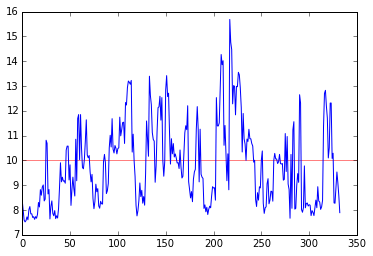

 Completed run for Caspr2

Name of Peptide Cftr
Base Energy 14.1698343588
Base Sequence ['Q', 'E', 'T', 'R', 'L']

 Cycle number : 1

Lowest Energy 14.1698343588 Sequence ['Q', 'E', 'T', 'R', 'L']



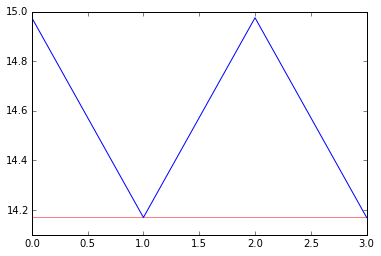

 Completed run for Cftr

Name of Peptide Claudin1
Base Energy 5.85361214727
Base Sequence ['G', 'K', 'D', 'Y', 'V']

 Cycle number : 1

Lowest Energy 4.99897492754 Sequence ['P', 'E', 'G', 'Y', 'P']



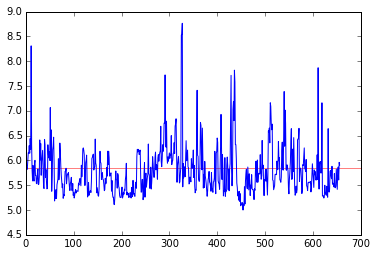

 Completed run for Claudin1

Name of Peptide Cnksr2
Base Energy 12.8739101795
Base Sequence ['I', 'E', 'T', 'H', 'V']

 Cycle number : 1

Lowest Energy 12.8549599199 Sequence ['L', 'E', 'T', 'H', 'V']



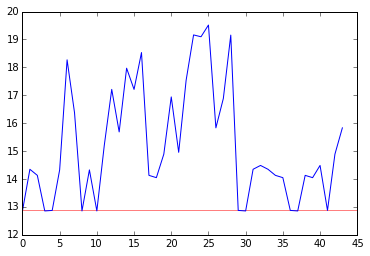

 Completed run for Cnksr2

Name of Peptide CRIPT
Base Energy 13.0315859943
Base Sequence ['K', 'Q', 'T', 'S', 'V']

 Cycle number : 1

Lowest Energy 13.0315859943 Sequence ['K', 'Q', 'T', 'S', 'V']



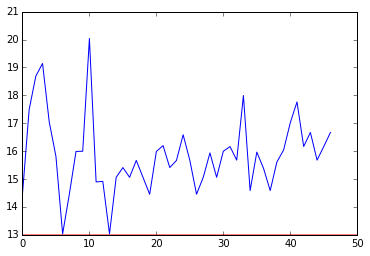

 Completed run for CRIPT

Name of Peptide Dlgap123
Base Energy 8.70586029191
Base Sequence ['A', 'Q', 'T', 'R', 'L']

 Cycle number : 1

Lowest Energy 8.70586029191 Sequence ['A', 'Q', 'T', 'R', 'L']



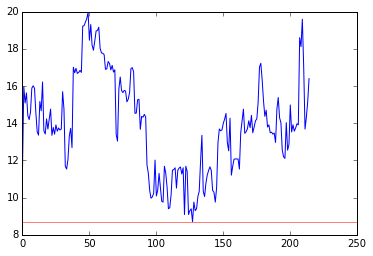

 Completed run for Dlgap123

Name of Peptide EphA71
Base Energy 9.01486396381
Base Sequence ['T', 'G', 'I', 'Q', 'V']

 Cycle number : 1

Lowest Energy 8.21671348834 Sequence ['T', 'E', 'L', 'Q', 'V']



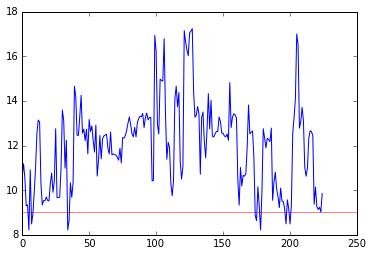

 Completed run for EphA71

Name of Peptide Frizzled
Base Energy 12.3844899453
Base Sequence ['G', 'E', 'T', 'T', 'V']

 Cycle number : 1

Lowest Energy 12.2089127441 Sequence ['T', 'E', 'T', 'T', 'V']



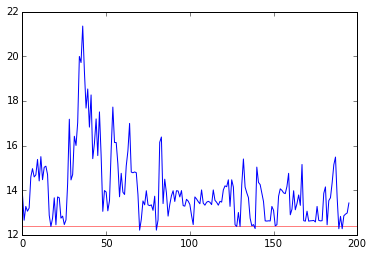

 Completed run for Frizzled

Name of Peptide Htr2c
Base Energy 8.13818772747
Base Sequence ['R', 'I', 'S', 'S', 'V']

 Cycle number : 1

Lowest Energy 8.10181627933 Sequence ['R', 'I', 'S', 'S', 'I']



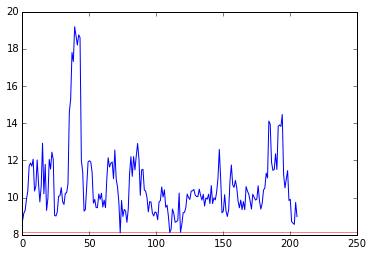

 Completed run for Htr2c

Name of Peptide Kv1.4
Base Energy 13.907492338
Base Sequence ['V', 'E', 'T', 'D', 'V']

 Cycle number : 1

Lowest Energy 10.7673190125 Sequence ['V', 'E', 'T', 'D', 'C']



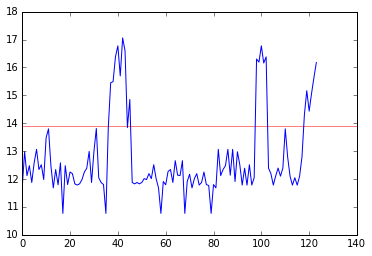

 Completed run for Kv1.4

Name of Peptide Megalin
Base Energy 9.94887572904
Base Sequence ['E', 'D', 'S', 'D', 'V']

 Cycle number : 1

Lowest Energy 5.87977011692 Sequence ['C', 'D', 'A', 'D', 'V']



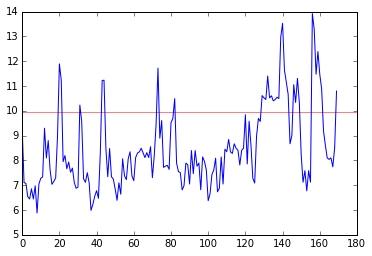

 Completed run for Megalin

Name of Peptide Nav1.4
Base Energy 20.3470673259
Base Sequence ['K', 'E', 'S', 'L', 'V']

 Cycle number : 1

Lowest Energy 20.3470673259 Sequence ['K', 'E', 'S', 'L', 'V']



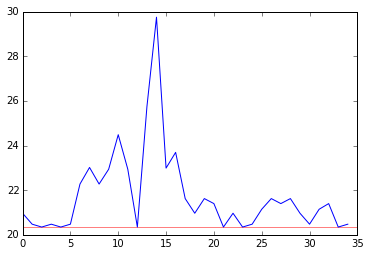

 Completed run for Nav1.4

Name of Peptide PMCA1
Base Energy 17.0781821932
Base Sequence ['L', 'E', 'T', 'S', 'L']

 Cycle number : 1

Lowest Energy 17.0781821932 Sequence ['L', 'E', 'T', 'S', 'L']



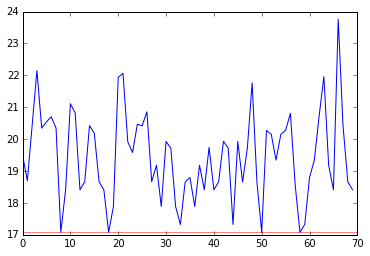

 Completed run for PMCA1

Name of Peptide Sapk3
Base Energy 15.3708590972
Base Sequence ['K', 'E', 'T', 'A', 'L']

 Cycle number : 1

Lowest Energy 15.3708590972 Sequence ['K', 'E', 'T', 'A', 'L']



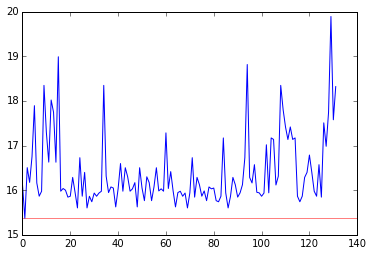

 Completed run for Sapk3

Name of Peptide SSTR2
Base Energy 14.6245810394
Base Sequence ['I', 'I', 'A', 'W', 'V']

 Cycle number : 1

Lowest Energy 14.6245810394 Sequence ['I', 'I', 'A', 'W', 'V']



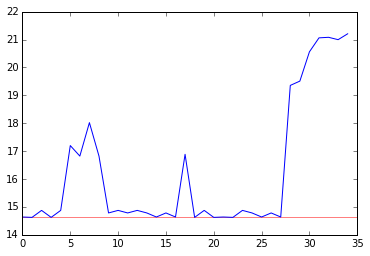

 Completed run for SSTR2

Name of Peptide TAZ
Base Energy 13.6522407003
Base Sequence ['F', 'L', 'T', 'W', 'L']

 Cycle number : 1

Lowest Energy 13.4926539825 Sequence ['F', 'L', 'T', 'W', 'M']



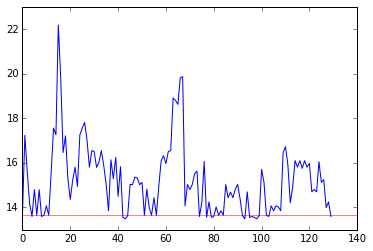

 Completed run for TAZ

Name of Peptide Kv1.7
Base Energy 11.5358511733
Base Sequence ['M', 'V', 'T', 'E', 'V']

 Cycle number : 1

Lowest Energy 11.5358511733 Sequence ['M', 'V', 'T', 'E', 'V']



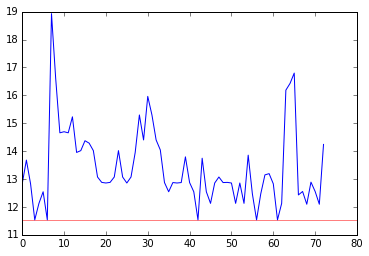

 Completed run for Kv1.7



In [563]:
entropies_bn = []
for bn in peptide_dist.keys():
    ## For each bn, we take one example, perform mutations on this peptide and track the entropies.
    
    temp_peptide = peptide_dist[bn][0]
    run_mc(1000, temp_peptide,beta=1.0, nb_cycles = 1, plot = True, verbose=False, print_reject=False)
    entropies_bn.append(compute_entropy(temp_peptide))    

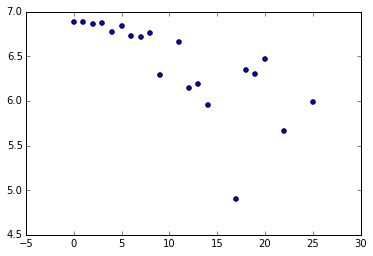

In [564]:
plt.scatter(np.asarray(peptide_dist.keys()), np.asarray(entropies_bn))

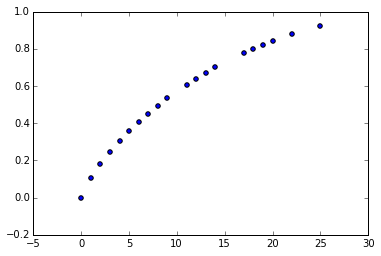

In [551]:
plt.scatter(np.asarray(peptide_dist.keys()), np.asarray(entropies))

## Observations 

1. We observe that the positions 1,2,3 are the ones which are the most highly constrained. 



# Variation of Entropy and Ground Energy with Binding Number

In [348]:
energy_entropy = OrderedDict()
entropies = []
for bn in peptide_dist.keys():
    peps_bn = peptide_dist[bn]
    bn_energies = [peptide.energy_ground for peptide in peps_bn]
    bn_entropies = [peptide.entropy for peptide in peps_bn]
    energy_entropy[bn]= bn_energies 
    entropies.append(np.max(bn_entropies))
    

In [363]:
ens = [np.min(value) for key, value in energy_entropy.iteritems()]
ens

[2.6755810837976504,
 -1.2813848382570515e-15,
 4.1805580377069917,
 7.0438920921773462,
 14.169834358770769,
 5.1448764653854324,
 12.873910179524502,
 13.031585994272405,
 7.8998479656060505,
 8.7636300702184382,
 11.601090602349316,
 8.1381877274703225,
 8.3859264385961083,
 5.9782808563425194,
 20.347067325873862,
 17.078182193197822,
 15.370859097189268,
 14.624581039409819,
 13.652240700311404,
 11.535851173292663]

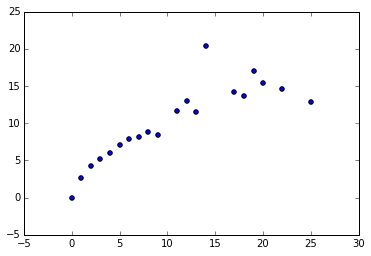

In [364]:
plt.scatter(np.asarray(peptide_dist.keys()), np.asarray(ens))